In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp /content/gdrive/MyDrive/projects/'table detection'/data/original.zip .
!unzip -q original.zip
!rm original.zip

In [ ]:
!pip -q install pycocotools --quiet

!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!pip install --upgrade --force-reinstall --no-deps albumentations

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./


Cloning into 'vision'...
remote: Enumerating objects: 30340, done.
remote: Counting objects: 100% (2883/2883), done.
remote: Compressing objects: 100% (731/731), done.
remote: Total 30340 (delta 2199), reused 2727 (delta 2095), pack-reused 27457
Receiving objects: 100% (30340/30340), 37.92 MiB | 35.56 MiB/s, done.
Resolving deltas: 100% (22815/22815), done.
fatal: not a git repository (or any of the parent directories): .git
     |████████████████████████████████| 102kB 10.1MB/s 
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# Pytorch Implementation of FasterRCNN Table Detection
In this notebook, I am going to finetune FasterRCNN model for detecting tables in documents. 

##Inputs To FasterRCNN:
	During Training:
		1) List of tensors, each of shape [C, H, W], one for each image.
		2) Targets: It is a dictionary for each image containing:
			a) boxes('FloatTensor[N, 4]') like [x1, y1, x2, y2] for each table bounding box in image
			b) labels(Int64Tensor[N]): the class label for each ground-truth box 
	
##Inferencing FasterRCNN:
	1) We give the input tensors to model
	2) It returns the post-processed predictions as a List[Dict[Tensor]]
		a) boxes('FloatTensor[N, 4]') like [x1, y1, x2, y2] for each predicted table bounding box 
		b) labels(Int64Tensor[N]): the predicted label for each image
		c) scores(Tensor[N]): the score for each prediction 

###Mounting to Drive

###Unzipping the orginal folder containing images and annotations

### All the imports required in the Implementation

In [ ]:
import os
import cv2
import numpy as np
import  xml.dom.minidom


# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T
from torchvision import transforms as torchtrans  


#Faster RCNN Model

Here I am getting a pretrained model of fasterRCNN and replacing its head for my classes prediction once fine-tuned

In [ ]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator


In [ ]:
def get_table_detection_model(num_classes):

  # Getting the pretrained model from torchvision
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  
  # Getting the number of input features to give to our classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features

  # Replacing the pretrained head with my own for finetuning for my classes
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model

#Making Dataset

In [ ]:
class TableDetectionDataset(torch.utils.data.Dataset):

    def __init__(self, images_dir, annot_dir, width, height, transforms=None):
        self.transforms = transforms
        self.images_dir = images_dir
        self.annot_dir = annot_dir
        self.height = height
        self.width = width

        # Sorting and checking if images are png
        self.imgs = [image for image in sorted(os.listdir(images_dir))
                        if image [-4:] == '.png']

        # Index 0 is for background
        self.classes = [_, 'table']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.images_dir, img_name)

        # reading the images and converting them to correct size and color
        img = cv2.imread(image_path)
        img_rgb=cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # normalizing by dividing by 255
        img_res /= 255.0

        # annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.annot_dir, annot_filename)


        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]



        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            if(xmax_corr < xmin_corr):
              print("It Happened within x")
              xmax_corr, xmin_corr = xmin_corr, xmax_corr

            if(ymax_corr < ymin_corr):
              print("It Happened within y")
              ymax_corr, ymin_corr = ymin_corr, ymax_corr
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])

            
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # if(xmin_corr > xmax_corr):
        #   return None
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                    bboxes = target['boxes'],
                                    labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)
        





In [ ]:
images_dir = "/content/Original/images"
annot_dir = "/content/Original/annotations"


# print(files_dir)

# check dataset
dataset = TableDetectionDataset(images_dir, annot_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[78]
print(img.shape, '\n',target)

length of dataset =  1123 

(224, 224, 3) 
 {'boxes': tensor([[ 51.2748,  29.1566, 201.2680, 208.6093]]), 'labels': tensor([1]), 'area': tensor([26916.6875]), 'iscrowd': tensor([0]), 'image_id': tensor([78])}


In [ ]:
len(dataset)

# count1 = 0
# count2 = 0
# try:
#   for img, target in dataset:
#     print(target)
#     # count+=1
#     # for box in (target['boxes']):
#     #   for i in range(4):
#     #     if (box[i]<0) :
#     #       box[i]=0
#     #     elif (box[i]>1) :
#     #       box[i]=1
#     #   box=tuple(box)    

# except:
#   print("error occured")
#   count2+=1
# print(count, count2)

#Visualization of Data

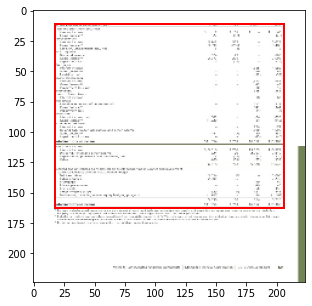

In [ ]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[680]
plot_img_bbox(img, target)

#Augmentations

In [ ]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    
    if train:
        return A.Compose([
                            
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ]) #,bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ]) #,bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

#Making Training and Testing Dataloaders

In [ ]:
# use our dataset and defined transformations
dataset = TableDetectionDataset(images_dir, annot_dir, 480, 480, transforms= get_transform(train=True))
dataset_test = TableDetectionDataset(images_dir, annot_dir, 480, 480, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
collate_fn=utils.collate_fn)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data_iter = iter(data_loader)

# images, targets = data_iter.next()

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# for k,v in t.items():
#   print(k)

# for t in targets

# print(t)
# trgts = [{k: v.to(device) for k, v in targets.items()}]
trgts = {}

for t in targets: 
  for k,v in t.items():
    trgts[k] = v.to(device)

for x in trgts:
  print(x)

batch_list = []

for i in range(5):
  images, targets = data_iter.next()


# print(type(trgts))

NameError: ignored

In [ ]:
targets[9]

In [ ]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 2

# get the model using our helper function
model = get_table_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
# training for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    torch.save(model.state_dict(), '/content/gdrive/MyDrive/projects/table detection/myModel.pth')
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0]  [ 0/90]  eta: 0:22:46  lr: 0.000061  loss: 1.2238 (1.2238)  loss_classifier: 0.9737 (0.9737)  loss_box_reg: 0.0870 (0.0870)  loss_objectness: 0.1410 (0.1410)  loss_rpn_box_reg: 0.0220 (0.0220)  time: 15.1801  data: 12.2653  max mem: 7153
Epoch: [0]  [10/90]  eta: 0:04:49  lr: 0.000622  loss: 0.7352 (0.7014)  loss_classifier: 0.3737 (0.4715)  loss_box_reg: 0.1014 (0.0956)  loss_objectness: 0.0730 (0.1010)  loss_rpn_box_reg: 0.0220 (0.0332)  time: 3.6169  data: 1.5746  max mem: 7419
Epoch: [0]  [20/90]  eta: 0:03:26  lr: 0.001184  loss: 0.2467 (0.4779)  loss_classifier: 0.1138 (0.2969)  loss_box_reg: 0.0997 (0.0957)  loss_objectness: 0.0255 (0.0617)  loss_rpn_box_reg: 0.0125 (0.0235)  time: 2.3338  data: 0.3621  max mem: 7419
Epoch: [0]  [30/90]  eta: 0:02:44  lr: 0.001745  loss: 0.1994 (0.3790)  loss_classifier: 0.0789 (0.2197)  loss_box_reg: 0.0901 (0.0918)  loss_objectness: 0.0178 (0.0476)  loss_rpn_box_reg: 0.0106 (0.0200)  time: 2.2700  data: 0.3010  max mem: 7419
Epoch:

NameError: ignored

#Testing Model

In [ ]:
num_classes = 2
PATH = '/content/gdrive/MyDrive/projects/table detection/experiments/exp1/myModel.pth'

# get the model using our helper function
model = get_table_detection_model(num_classes)
model.load_state_dict(torch.load(PATH))
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')


In [ ]:
model.to(device)

# pick one image from the test set
img, target = dataset_test[0]

# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  5
real #boxes:  1


EXPECTED OUTPUT


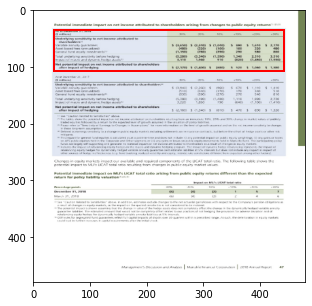

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

MODEL OUTPUT


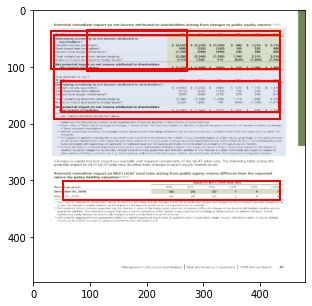

In [ ]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

NMS APPLIED MODEL OUTPUT


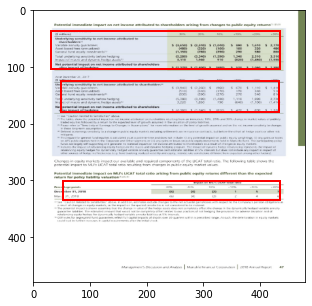

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)

EXPECTED OUTPUT



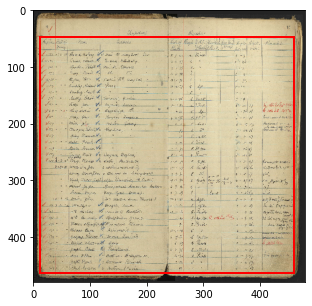

MODEL OUTPUT



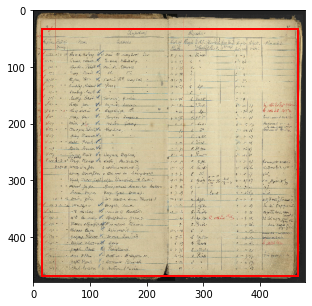

In [ ]:
# pick one image from the test set
img, target = dataset_test[10]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction)